# Classifying dolphin whistle sounds with a Convolutional Neural Network

This jupyter notebook creates a model, trains it and evaluates it.

This code is fully os-independent and fs-independent, so you don't have to worry whether you are running on a windows os or IOS or linux, they will all work. But do make sure you set up a virtual environment correctly before continuing.

Import relevant packages. Set up the virtual environment as specified in the README file to avoid "dependency-hell".

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models  # For specifying the type of layer (Dense)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path


# Generate Training, Validation and Test Datasets

Here we generate training, validation datasets from the training data directory TRAIN_DATA_DIR and testing datasets from the testing data directory TEST_DATA_DIR

Before running the following cell, change the relative paths to the folders on your machine.

In [3]:
TRAINING_DATA_DIR = Path("/Users/matteohe/Desktop/DA/full-dclde-imgs/training-data")
TEST_DATA_DIR = Path("/Users/matteohe/Desktop/DA/full-dclde-imgs/testing-data")

X, Y = 413, 202
IMAGE_SHAPE = (X, Y) # (row, col) format for imshow and (height, width) for ImageDataGenerator
VALIDATION_SPLIT = 0.20 # validation split from the training data set

The default here is to keep the shuffle parameter to false, since it is pretty much pointless to shuffle the testing data as weights are not updated during the testing phase. But if you are testing something you should change it to true with the following caveat:

**NB: If you change the shuffle option in test_generator code to true (in case a metric you want to test requires the order to be shuffled), be mindful of what you did and definitely change the code in the bottom of this file in the Evaluation section, more specifically: the truth labels will need to be collected in a different way than it is right now in the classification report and confusion matrix code blocks.**

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, validation_split=VALIDATION_SPLIT
)  # https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, subset="training", shuffle=True, target_size=IMAGE_SHAPE
)

validation_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, subset="validation", shuffle=True, target_size=IMAGE_SHAPE
)

test_generator = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    TEST_DATA_DIR, shuffle=False, target_size=IMAGE_SHAPE
) 

Found 4777 images belonging to 3 classes.
Found 1193 images belonging to 3 classes.
Found 2557 images belonging to 3 classes.


## Building a CNN model and stacking the layers

This section is dedicated to creating CNN models

Configurations code for the model. There are a lot of things still worth exploring with the following model code. One thing that can be done is experimenting with dropout layers

In [8]:
KERNEL_SIZE = (3, 3) # 3x3 is the optimal size of a kernel 3x3 as agreed by the computing community
INPUT_SHAPE = (X, Y, 3)
LAYERS = 16

In [9]:
# instantiate model object
model = models.Sequential()

# Stack layers on the sequential base model
model.add(layers.Conv2D(LAYERS, KERNEL_SIZE, activation="relu", input_shape=INPUT_SHAPE))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(LAYERS, KERNEL_SIZE, activation="relu"))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(LAYERS, KERNEL_SIZE, activation="relu"))
model.add(BatchNormalization())

# Add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(layers.Dense(3, activation="softmax"))

# print out summary of code
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 411, 200, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 411, 200, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 205, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 203, 98, 32)       9248      
                                                                 
 batch_normalization_1 (Batc  (None, 203, 98, 32)      128       
 hNormalization)                                                 
                                                      

# Training the CNN model

Configurations code for the CNN training process.

In [12]:
# compile model
model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Configurations
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size
NUM_EPOCHS = 11
ES = EarlyStopping("val_loss", mode="auto", verbose=1, patience=5)

Train the network.

In [6]:
# Training the network
print("[INFO] training network for {} epochs...".format(NUM_EPOCHS))
fitted = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=NUM_EPOCHS,
    callbacks=[ES],
)


[INFO] compiling model...
[INFO] training network for 11 epochs...
Epoch 1/11
149/149 [==============================] - 257s 2s/step - loss: 0.5527 - accuracy: 0.7945 - val_loss: 2.3982 - val_accuracy: 0.3851
Epoch 2/11
149/149 [==============================] - 253s 2s/step - loss: 0.1232 - accuracy: 0.9646 - val_loss: 4.3180 - val_accuracy: 0.3564
Epoch 3/11
149/149 [==============================] - 248s 2s/step - loss: 0.0672 - accuracy: 0.9810 - val_loss: 1.8940 - val_accuracy: 0.4958
Epoch 4/11
149/149 [==============================] - 241s 2s/step - loss: 0.0191 - accuracy: 0.9973 - val_loss: 2.7326 - val_accuracy: 0.5549
Epoch 5/11
149/149 [==============================] - 4594s 31s/step - loss: 0.0136 - accuracy: 0.9981 - val_loss: 5.8874 - val_accuracy: 0.4797
Epoch 6/11
149/149 [==============================] - 254s 2s/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 1.0536 - val_accuracy: 0.6765
Epoch 7/11
149/149 [==============================] - 256s 2s/step - loss

# Evaluating the CNN model

### Validation and training accuracy history plot:

In [13]:
# Evalutate the network - use validation set
print("[INFO] evaluating network...")

plt.plot(fitted.history["accuracy"], label="accuracy")
plt.plot(fitted.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.title("Validation and Training accuracy")
plt.legend(loc="lower right")

[INFO] evaluating network...


NameError: name 'fitted' is not defined

### Validation and Training Loss History Plot:

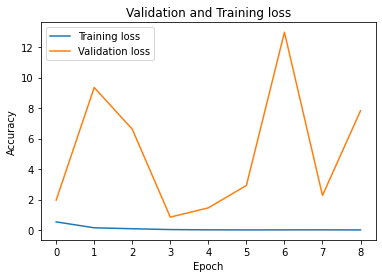

In [47]:
# Evalutate the network - use validation set
print("[INFO] evaluating network...")

plt.plot(fitted.history["loss"], label="Training loss")
plt.plot(fitted.history["val_loss"], label="Validation loss")
plt.title("Validation and Training loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

### Printing a summary of the statistics with model evaluation

In [ ]:
test_loss, test_acc = model.evaluate(
    test_generator, verbose=2
)  # Check the return values for this

print("----- Evaluation Summary statistics -----")
print("Test accuracy = ", test_acc)
print("Test loss = ", test_loss)

### Classification Report of the model

NB: the code below this point will not work and will produce misleading results if the test data is shuffled in the test_generator code. If you did that please change the way you get the predicted labels. You will most likely need to collect them by iterating through the test_generator to get the labels from all the batches. Of course it would be easier if the batch size includes all the data at once.

In [64]:
print("Running Classification Report...")
test_generator.reset()
# get the predicted scores for each class
scores = model.predict(test_generator)
# get the label with the highest prediction
predicted_labels = scores.argmax(axis=1)
# get ground truth labels from test_generator.classes
true_labels = test_generator.classes

# gets class names
species = dict((v,k) for k,v in (train_generator.class_indices).items())
species_names = np

print(
    classification_report(
        true_labels, 
        predicted_labels, 
        target_names = species_names)
)

Running Classification Report...
{0: 'bottlenose', 1: 'common', 2: 'melon-headed'}


### Confusion Matrix of the model

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_names)
display.plot()

## Save
The current naming format has been decided to be "date-modelname".

In [10]:
from datetime import date
today = date.today()
today = str(today)

In [12]:
# Save the trained model -> could save just the weights or the entire architecture
model_name = "-eric"
model.save(today + model_name + '.model')

INFO:tensorflow:Assets written to: 2022-04-04-eric.model/assets
